# ターボファンエンジンの診断システム構築

## 目的
- ターボファンエンジンの診断システムを構築する
    - システムの機能：
        - エンジンの現状把握（センサーデータの可視化）
        - 故障までのデータがない場合、異常検知手法も用いてエンジンの状態警告モデル
        - 故障までのデータがある場合、エンジンの状態を分類するモデル
        - 故障までのデータがある場合、エンジンの残存耐用期間（RUL）予測モデル

## このノートブックの目的
- 故障データがない場合、エンジンの状態警告モデル
    - 故障の閾値は現場の専門家（現場のエンジニア）と協力し、故障の閾値を手動で決める

## インポート

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import japanize_matplotlib
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#others
import os
import gc
import pickle

In [2]:
# pandasの設定
pd.set_option('display.max_columns',  50)
pd.set_option('display.max_rows', 100)

# 図の設定
mpl.rc('axes', titlesize=18)
mpl.rc('axes', labelsize=16)
mpl.rc('xtick', labelsize=16)
mpl.rc('ytick', labelsize=16)
mpl.rc('xtick', direction='in')
mpl.rc('ytick', direction='in')
mpl.rc('legend', fontsize=16)

# 図のサイズ
FIGURE_HEIGHT = 5
FIGURE_WIDTH = 5 * 1.414

# 色の設定
from cycler import cycler
import matplotlib.colors as mcolors
colors = mcolors.TABLEAU_COLORS
mpl.rcParams['axes.prop_cycle']  = cycler(color = [c for c in colors.values()])

## データロード

In [3]:
data_dir = Path("../data/CMaps")
train_raw_dir = data_dir / "train_FD001.txt"
test_raw_dir = data_dir / "test_FD001.txt"
rul_raw_dir = data_dir / "RUL_FD001.txt"

In [4]:
# adding columns' name
index_names = ['Unit', 'Time']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = {'s_1': 'FanInletTemp',
                 's_2': 'LPCOutletTemp',
                 's_3': 'HPCOutletTemp',
                 's_4': 'LPTOutletTemp',
                 's_5': 'FanInletPres',
                 's_6': 'BypassDuctPres',
                 's_7': 'TotalHPCOutletPres',
                 's_8': 'PhysFanSpeed',
                 's_9': 'PhysCoreSpeed',
                 's_10': 'EnginePresRatio',
                 's_11': 'StaticHPCOutletPres',
                 's_12': 'FuelFlowRatio',
                 's_13': 'CorrFanSpeed',
                 's_14': 'CorrCoreSpeed',
                 's_15': 'BypassRatio',
                 's_16': 'BurnerFuelAirRatio',
                 's_17': 'BleedEnthalpy',
                 's_18': 'DemandFanSpeed',
                 's_19': 'DemandCorrFanSpeed',
                 's_20': 'HPTCoolantBleed',
                 's_21': 'LPTCoolantBleed'
               }

In [5]:
# all columns' name
variable_names = index_names + setting_names + [sensor_name for sensor_name in sensor_names.values()]

In [6]:
train_df = pd.read_csv(train_raw_dir, 
                    sep='\s+', 
                    header=None,
                    index_col=False,
                    names=variable_names)
train = train_df.copy()

test_df = pd.read_csv(test_raw_dir, 
                    sep='\s+', 
                    header=None,
                    index_col=False,
                    names=variable_names)
test = test_df.copy()

y_test = pd.read_csv(rul_raw_dir, 
                     sep='\s+', 
                     header=None,
                     index_col=False,
                     names=['RUL'])

In [7]:
train.shape

(20631, 26)

In [8]:
train.head()

,Unit,Time,setting_1,setting_2,setting_3,FanInletTemp,LPCOutletTemp,HPCOutletTemp,LPTOutletTemp,FanInletPres,BypassDuctPres,TotalHPCOutletPres,PhysFanSpeed,PhysCoreSpeed,EnginePresRatio,StaticHPCOutletPres,FuelFlowRatio,CorrFanSpeed,CorrCoreSpeed,BypassRatio,BurnerFuelAirRatio,BleedEnthalpy,DemandFanSpeed,DemandCorrFanSpeed,HPTCoolantBleed,LPTCoolantBleed
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [9]:
train.loc[:,'FanInletTemp':].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
FanInletTemp,20631.0,518.670000,0.000000e+00,518.6700,518.6700,518.6700,518.6700,518.6700
LPCOutletTemp,20631.0,642.680934,5.000533e-01,641.2100,642.3250,642.6400,643.0000,644.5300
HPCOutletTemp,20631.0,1590.523119,6.131150e+00,1571.0400,1586.2600,1590.1000,1594.3800,1616.9100
LPTOutletTemp,20631.0,1408.933782,9.000605e+00,1382.2500,1402.3600,1408.0400,1414.5550,1441.4900
FanInletPres,20631.0,14.620000,1.776400e-15,14.6200,14.6200,14.6200,14.6200,14.6200
BypassDuctPres,20631.0,21.609803,1.388985e-03,21.6000,21.6100,21.6100,21.6100,21.6100
TotalHPCOutletPres,20631.0,553.367711,8.850923e-01,549.8500,552.8100,553.4400,554.0100,556.0600
PhysFanSpeed,20631.0,2388.096652,7.098548e-02,2387.9000,2388.0500,2388.0900,2388.1400,2388.5600
PhysCoreSpeed,20631.0,9065.242941,2.208288e+01,9021.7300,9053.1000,9060.6600,9069.4200,9244.5900
EnginePresRatio,20631.0,1.300000,0.000000e+00,1.3000,1.3000,1.3000,1.3000,1.3000


In [10]:
train['Time'].describe(percentiles=[0.1,0.5,0.9]).T

count    20631.000000
mean       108.807862
std         68.880990
min          1.000000
10%         21.000000
50%        104.000000
90%        199.000000
max        362.000000
Name: Time, dtype: float64

## 残存耐用時間（RUL)を算出する

In [11]:
def add_remaining_useful_life(df: pd.DataFrame) -> pd.DataFrame:
    """残存耐用時間を追加する関数

    Args:
        df (pd.DataFrame): ローデータ

    Returns:
        pd.DataFrame: 残存耐用時間を追加したデータフレーム
    """

    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by="Unit")
    max_cycle = grouped_by_unit["Time"].max()
    
    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='Unit', right_index=True)
    
    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame["Time"]
    result_frame["RUL"] = remaining_useful_life
    
    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame

train = add_remaining_useful_life(train)
train[index_names+['RUL']].head()

,Unit,Time,RUL
0,1,1,191
1,1,2,190
2,1,3,189
3,1,4,188
4,1,5,187


## エンジンNo1を可視化

In [12]:
plot_col_lst = variable_names[2:]

In [13]:
print(plot_col_lst)

['setting_1', 'setting_2', 'setting_3', 'FanInletTemp', 'LPCOutletTemp', 'HPCOutletTemp', 'LPTOutletTemp', 'FanInletPres', 'BypassDuctPres', 'TotalHPCOutletPres', 'PhysFanSpeed', 'PhysCoreSpeed', 'EnginePresRatio', 'StaticHPCOutletPres', 'FuelFlowRatio', 'CorrFanSpeed', 'CorrCoreSpeed', 'BypassRatio', 'BurnerFuelAirRatio', 'BleedEnthalpy', 'DemandFanSpeed', 'DemandCorrFanSpeed', 'HPTCoolantBleed', 'LPTCoolantBleed']


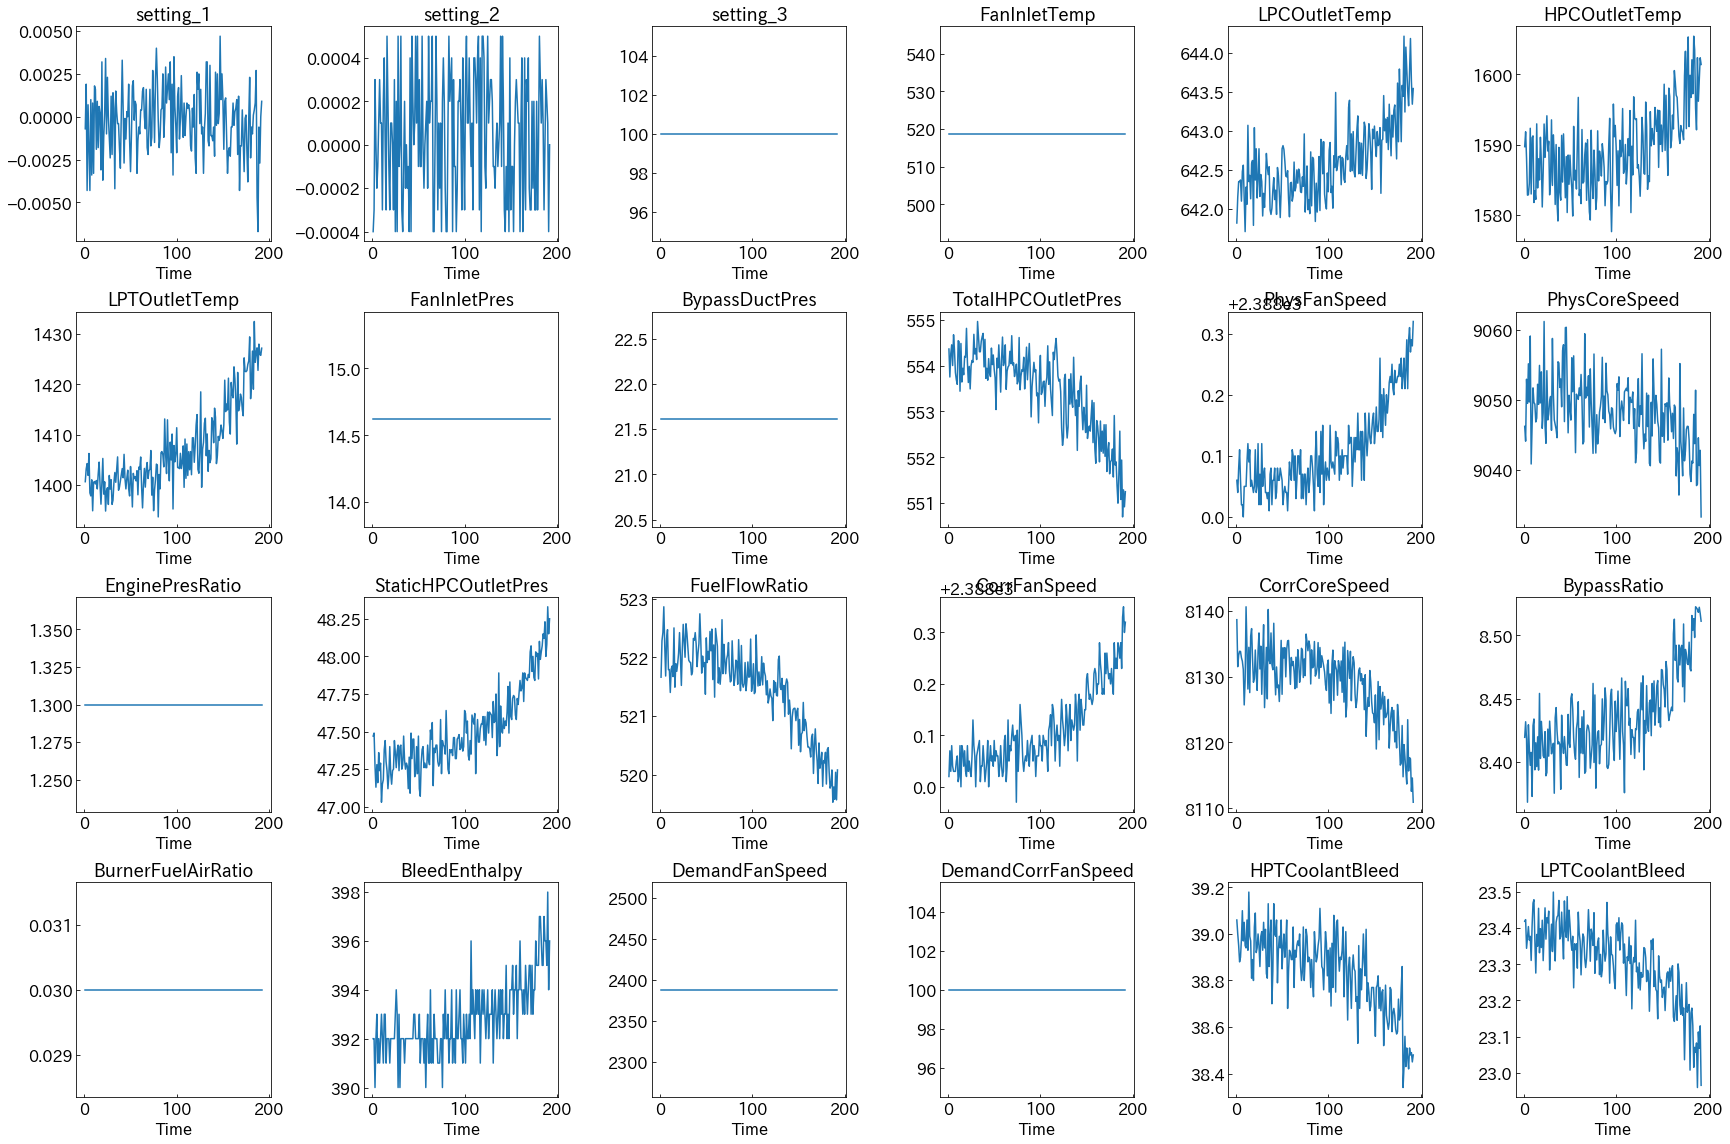

In [14]:
fig = plt.figure(figsize=(24,16))
nrows = 4
ncols = 6
unit_id = 1
for index, col in enumerate(plot_col_lst):
    ax = fig.add_subplot(nrows, ncols, index + 1)
    ax.plot('Time',col, data=train[train['Unit']==unit_id])
    ax.set_xlabel('Time')
    ax.set_title(col)
fig.tight_layout();

### 移動平均可視化

In [15]:
unit_id = 1
unit1_df = train[train['Unit']==unit_id].copy()

In [16]:
def calculate_moving_average(df, cols, window_range=5):
    mvavg_df = df[cols].rolling(window=window_range).mean()
    return mvavg_df

In [17]:
selected_sensors = ['LPCOutletTemp', 'HPCOutletTemp', 'LPTOutletTemp', 'TotalHPCOutletPres', 
                    'PhysFanSpeed', 'PhysCoreSpeed', 'StaticHPCOutletPres', 'FuelFlowRatio', 'CorrFanSpeed', 
                    'CorrCoreSpeed', 'BypassRatio', 'BleedEnthalpy', 'HPTCoolantBleed', 'LPTCoolantBleed']

In [18]:
smooth_data_unit1 = calculate_moving_average(unit1_df, selected_sensors)

In [19]:
smooth_data_unit1.tail()

,LPCOutletTemp,HPCOutletTemp,LPTOutletTemp,TotalHPCOutletPres,PhysFanSpeed,PhysCoreSpeed,StaticHPCOutletPres,FuelFlowRatio,CorrFanSpeed,CorrCoreSpeed,BypassRatio,BleedEnthalpy,HPTCoolantBleed,LPTCoolantBleed
187,643.690,1599.708,1426.654,551.646,2388.268,9043.722,48.114,519.798,2388.262,8117.222,8.51538,395.8,38.468,23.03640
188,643.712,1597.854,1425.752,551.586,2388.274,9043.050,48.116,519.760,2388.272,8117.602,8.51638,395.8,38.478,23.05602
189,643.680,1597.006,1426.062,551.516,2388.274,9042.424,48.152,519.804,2388.288,8117.380,8.52116,396.4,38.474,23.05552
190,643.646,1598.446,1425.956,551.186,2388.288,9040.702,48.158,519.702,2388.298,8115.612,8.52010,395.8,38.470,23.07014
191,643.690,1600.308,1425.942,551.220,2388.294,9039.804,48.162,519.812,2388.306,8114.664,8.51800,395.8,38.482,23.04668


In [20]:
smooth_data_unit1 = smooth_data_unit1.merge(train['Time'],how='left',right_index=True, left_index=True)

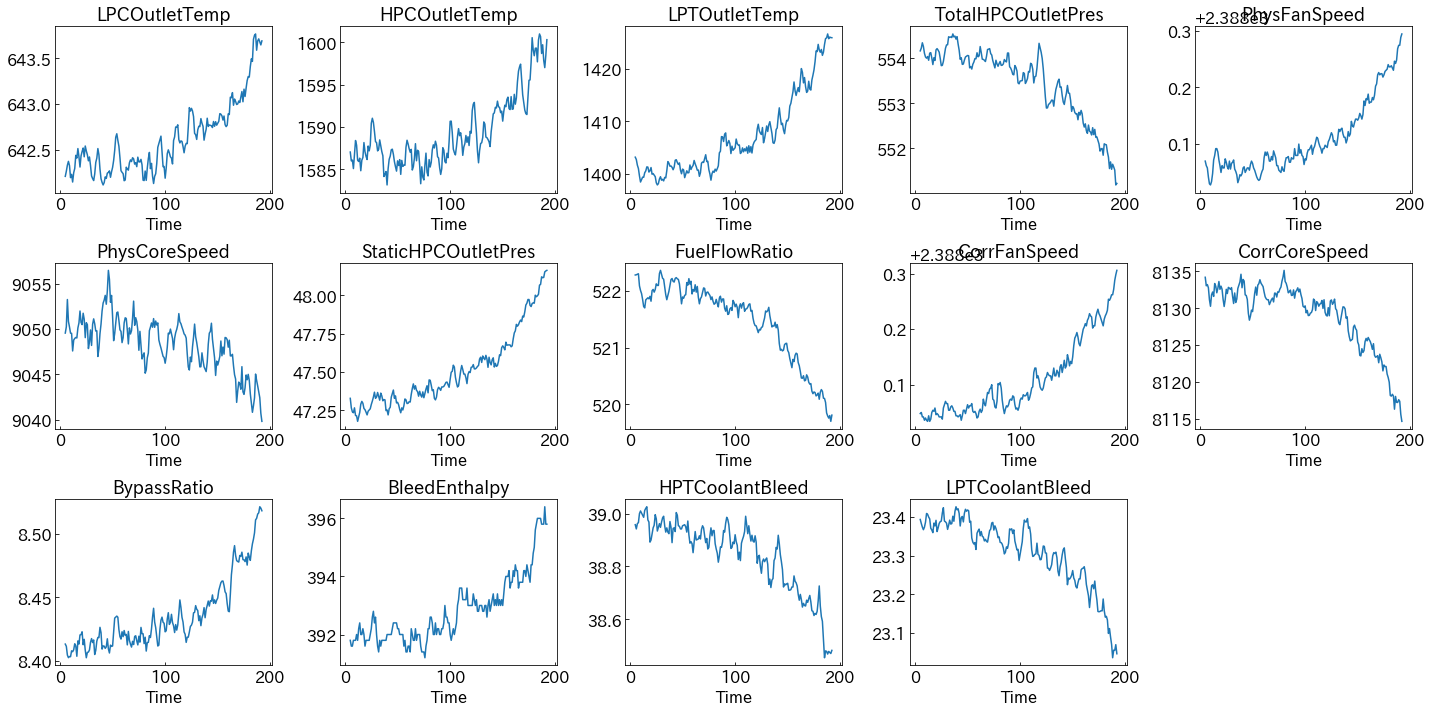

In [21]:
fig = plt.figure(figsize=(20,10))
nrows = 3
ncols = 5
for index, col in enumerate(selected_sensors):
    ax = fig.add_subplot(nrows, ncols, index + 1)
    ax.plot('Time',col, data=smooth_data_unit1)
    ax.set_xlabel('Time')
    ax.set_title(col)
fig.tight_layout();

In [22]:
# calculate std and set upper and lower boundary
sigma = np.std(unit1_df['LPCOutletTemp'])
mean = np.mean(unit1_df['LPCOutletTemp'])
lower_bound = mean - 2*sigma
upper_bound = mean + 2*sigma

59099

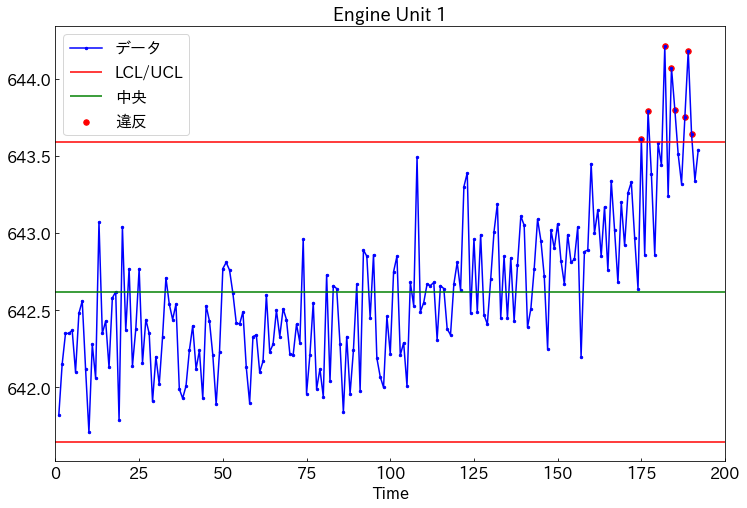

In [23]:
plt.figure(figsize=(12,8))
plt.plot('Time', 'LPCOutletTemp', data=unit1_df, color='b', ls='-', marker='o',ms=2.4, label='データ')
plt.hlines(y=lower_bound, xmin=0, xmax=200,color='r',label='LCL/UCL')
plt.hlines(y=mean, xmin=0, xmax=200, color='g', label='中央')
plt.hlines(y=upper_bound, xmin=0, xmax=200,color='r')

# draw abnormal values
_tmp = unit1_df.query("(LPCOutletTemp > @upper_bound) | (LPCOutletTemp < @lower_bound)")
plt.scatter('Time', 'LPCOutletTemp', data=_tmp, color='r', s=30, label='違反')
plt.xlabel("Time")
plt.title("Engine Unit 1")
plt.xlim([0,200])
plt.legend();

del _tmp
gc.collect()

## セベてのエンジンを選択

In [24]:
train[selected_sensors] = calculate_moving_average(train, selected_sensors)

In [25]:
train.head()

,Unit,Time,setting_1,setting_2,setting_3,FanInletTemp,LPCOutletTemp,HPCOutletTemp,LPTOutletTemp,FanInletPres,BypassDuctPres,TotalHPCOutletPres,PhysFanSpeed,PhysCoreSpeed,EnginePresRatio,StaticHPCOutletPres,FuelFlowRatio,CorrFanSpeed,CorrCoreSpeed,BypassRatio,BurnerFuelAirRatio,BleedEnthalpy,DemandFanSpeed,DemandCorrFanSpeed,HPTCoolantBleed,LPTCoolantBleed,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,NaN,NaN,NaN,14.62,21.61,NaN,NaN,NaN,1.3,NaN,NaN,NaN,NaN,NaN,0.03,NaN,2388,100.0,NaN,NaN,191
1,1,2,0.0019,-0.0003,100.0,518.67,NaN,NaN,NaN,14.62,21.61,NaN,NaN,NaN,1.3,NaN,NaN,NaN,NaN,NaN,0.03,NaN,2388,100.0,NaN,NaN,190
2,1,3,-0.0043,0.0003,100.0,518.67,NaN,NaN,NaN,14.62,21.61,NaN,NaN,NaN,1.3,NaN,NaN,NaN,NaN,NaN,0.03,NaN,2388,100.0,NaN,NaN,189
3,1,4,0.0007,0.0000,100.0,518.67,NaN,NaN,NaN,14.62,21.61,NaN,NaN,NaN,1.3,NaN,NaN,NaN,NaN,NaN,0.03,NaN,2388,100.0,NaN,NaN,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.208,1587.03,1403.206,14.62,21.61,554.164,2388.07,9049.566,1.3,47.328,522.282,2388.048,8134.194,8.41334,0.03,391.8,2388,100.0,38.958,23.39302,187


In [26]:
smooth_data_all = train[selected_sensors + ["Time"] + ["RUL"] + ["Unit"]]

In [27]:
smooth_data_all.head()

,LPCOutletTemp,HPCOutletTemp,LPTOutletTemp,TotalHPCOutletPres,PhysFanSpeed,PhysCoreSpeed,StaticHPCOutletPres,FuelFlowRatio,CorrFanSpeed,CorrCoreSpeed,BypassRatio,BleedEnthalpy,HPTCoolantBleed,LPTCoolantBleed,Time,RUL,Unit
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,191,1
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,190,1
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,189,1
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,188,1
4,642.208,1587.03,1403.206,554.164,2388.07,9049.566,47.328,522.282,2388.048,8134.194,8.41334,391.8,38.958,23.39302,5,187,1


In [28]:
# remove NAN values
smooth_data_all_all_cycle = smooth_data_all.dropna()

In [29]:
smooth_data_all_all_cycle[["Time","RUL"]].describe().T

,count,mean,std,min,25%,50%,75%,max
Time,20627.0,108.828477,68.871755,1.0,52.0,104.0,156.0,362.0
RUL,20627.0,107.792020,68.878271,0.0,51.0,103.0,155.0,361.0


In [30]:
# select data in Time range [5,125]
lower_lim = 5
upper_lim = 125
smooth_data_all = smooth_data_all.query("(Time >= @lower_lim) & (Time <= @upper_lim)")

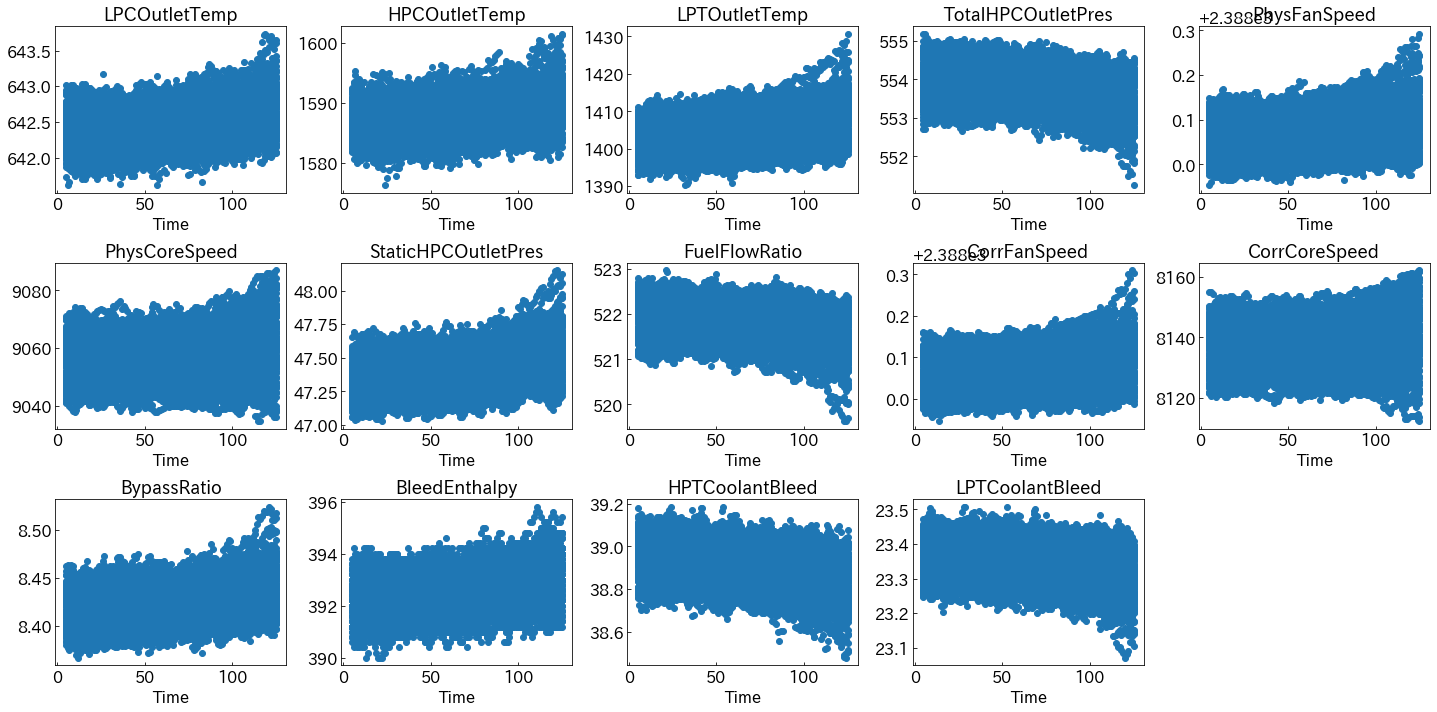

In [31]:
fig = plt.figure(figsize=(20,10))
nrows = 3
ncols = 5
for index, col in enumerate(selected_sensors):
    ax = fig.add_subplot(nrows, ncols, index + 1)
    ax.scatter('Time',col, data=smooth_data_all)
    ax.set_xlabel('Time')
    ax.set_title(col)
    # ax.set_xlim([5,125])
fig.tight_layout();

### データを標準化

In [32]:
# 学習データに基づいて複数列の標準化を定義
scaler = StandardScaler()
scaler.fit(smooth_data_all[selected_sensors])

# 変換後のデータで各列を置換
smooth_data_all[selected_sensors] = scaler.transform(smooth_data_all[selected_sensors])

In [33]:
pca_df = smooth_data_all[selected_sensors + ["RUL"] + ["Time"] + ["Unit"]]

In [34]:
pca_df.head()

,LPCOutletTemp,HPCOutletTemp,LPTOutletTemp,TotalHPCOutletPres,PhysFanSpeed,PhysCoreSpeed,StaticHPCOutletPres,FuelFlowRatio,CorrFanSpeed,CorrCoreSpeed,BypassRatio,BleedEnthalpy,HPTCoolantBleed,LPTCoolantBleed,RUL,Time,Unit
4,-0.935112,-0.305267,-0.290984,0.736586,-0.032102,-0.975333,-0.523378,1.139883,-0.441248,-0.509026,-0.570056,-0.903482,0.615069,0.897070,187,5,1
5,-0.739717,-0.625955,-0.374046,0.850175,-0.190085,-0.892210,-0.897484,1.148455,-0.402239,-0.650657,-0.650345,-1.143617,0.460379,0.730079,186,6,1
6,-0.509431,-0.595296,-0.574066,1.066360,-0.269076,-0.533520,-1.054367,1.165600,-0.558275,-0.630284,-0.967812,-1.143617,0.653741,0.581999,185,7,1
7,-0.362885,-0.903721,-0.694376,0.916130,-0.585041,-0.822663,-1.090571,1.187030,-0.558275,-0.683303,-1.061945,-0.903482,0.692413,0.474305,184,8,1
8,-0.523388,-0.401535,-0.957718,0.637654,-0.822014,-0.894592,-0.897484,0.728415,-0.675302,-0.883107,-1.019493,-0.903482,1.021128,0.579115,183,9,1


### 主成分分析による次元の低減

In [35]:
pca = PCA(n_components=10, random_state=10)
pca.fit(pca_df[selected_sensors])

PCA(n_components=10, random_state=10)

In [36]:
explained_ratio = pca.explained_variance_ratio_

In [37]:
cumsum = np.cumsum(pca.explained_variance_ratio_)

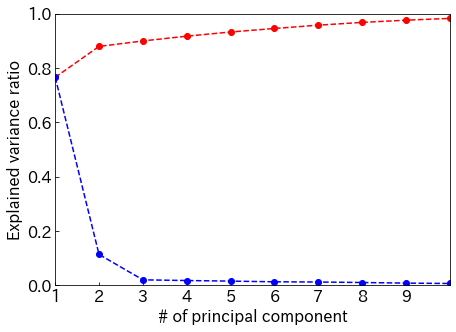

In [38]:
plt.figure(figsize=(FIGURE_WIDTH,FIGURE_HEIGHT))
plt.plot(np.arange(1,11), cumsum,'r--o')
plt.plot(np.arange(1,11), explained_ratio,'b--o')
plt.xlim([1,10])
plt.xticks(ticks=np.arange(1,10))
plt.ylim([0,1])
plt.ylabel("Explained variance ratio")
plt.xlabel("# of principal component");

In [39]:
# PCA with 2 components
pca2_df = pca_df.copy()
pca2 = PCA(n_components=2, random_state=10)

In [40]:
pca2_df = pd.DataFrame(data=pca2.fit_transform(pca2_df[selected_sensors]), 
                       columns=["component1","component2"])

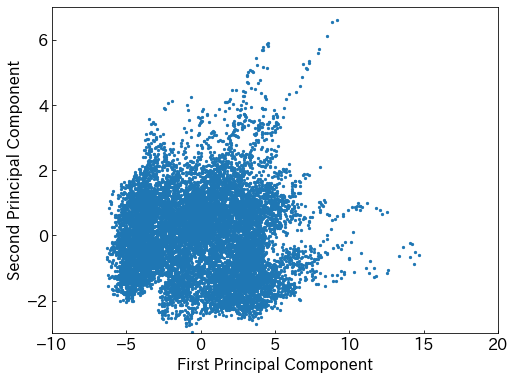

In [41]:
plt.figure(figsize=(8,6))
plt.scatter("component1", "component2", data=pca2_df, s=5)
plt.xlim([-10, 20])
plt.ylim([-3, 7])
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component");

## 警告システム

In [42]:
pca2_df.head()

,component1,component2
0,-1.835920,-1.607487
1,-2.050484,-1.702948
2,-2.373050,-1.476494
3,-2.407344,-1.679593
4,-2.290257,-1.773927


In [43]:
# add the Time cycle into the reduced pca2_df
pca2_df = pca2_df.merge(pca_df.reset_index(drop=True)[["RUL","Time","Unit"]], how='left', right_index=True, left_index=True)

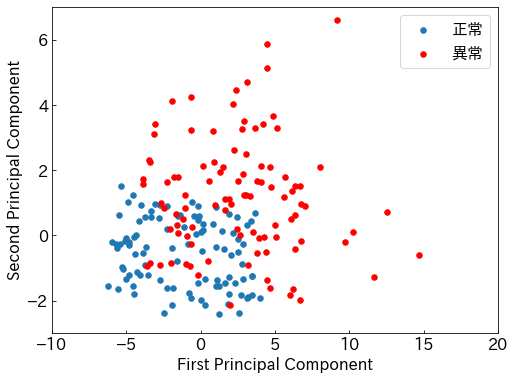

In [44]:
plt.figure(figsize=(8,6))
plt.scatter("component1", "component2", data=pca2_df.query("Time == 5"), s=30, label="正常")
plt.scatter("component1", "component2", data=pca2_df.query("Time == 125"), s=30, c='r', label="異常")
plt.xlim([-10, 20])
plt.ylim([-3, 7])
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.legend();


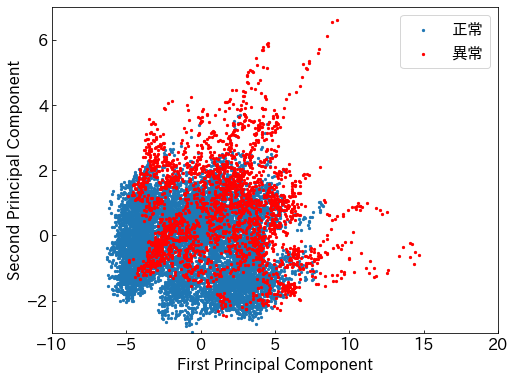

In [45]:
plt.figure(figsize=(8,6))
plt.scatter("component1", "component2", data=pca2_df.query("Time <= 100"), s=5, label="正常")
plt.scatter("component1", "component2", data=pca2_df.query("Time > 100"), s=5, c='r', label="異常")
plt.xlim([-10, 20])
plt.ylim([-3, 7])
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.legend();

**Adding centroid of two clusters**

In [46]:
early_points = pca2_df.query("Time <= 100")
late_points = pca2_df.query("Time > 100")

In [47]:
early_points_centroid_x = np.mean(early_points[['component1','component2']], axis=0)[0]
early_points_centroid_y = np.mean(early_points[['component1','component2']], axis=0)[1]

In [48]:
late_points_centroid_x = np.mean(late_points[['component1','component2']], axis=0)[0]
late_points_centroid_y = np.mean(late_points[['component1','component2']], axis=0)[1]

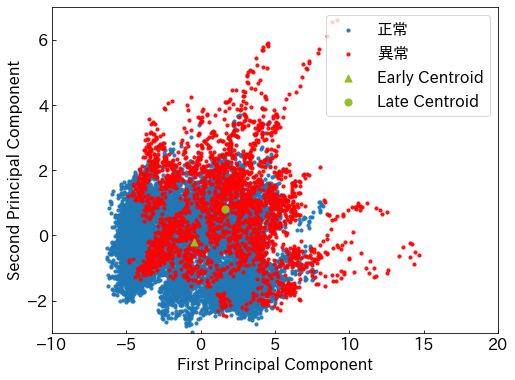

In [49]:
plt.figure(figsize=(8,6))
plt.scatter("component1", "component2", data=early_points, s=10, alpha=0.9, label="正常")
plt.scatter("component1", "component2", data=late_points, s=10, c='r',  alpha=0.9, label="異常")
plt.scatter(early_points_centroid_x, early_points_centroid_y, s=50, 
            c='#96be25', marker='^', label="Early Centroid")
plt.scatter(late_points_centroid_x, late_points_centroid_y, s=50, 
            c='#96be25', label="Late Centroid")
plt.xlim([-10, 20])
plt.ylim([-3, 7])
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.legend();

### 注意や警告の信号を発する基準

In [50]:
mean_c1 = np.mean(pca2_df[["component1","component2"]],axis=0)[0]
mean_c2 = np.mean(pca2_df[["component1","component2"]],axis=0)[1]

In [51]:
std_c1 = np.std(pca2_df[["component1","component2"]],axis=0)[0]
std_c2 = np.std(pca2_df[["component1","component2"]],axis=0)[1]

In [52]:
lower_90_c1 = mean_c1 - 1.645*std_c1
upper_90_c1 = mean_c1 + 1.645*std_c1
print(lower_90_c1, upper_90_c1)

-5.384612786425503 5.384612786425503


In [53]:
lower_99_c1 = mean_c1 - 3*std_c1
upper_99_c1 = mean_c1 + 3*std_c1
print(lower_99_c1, upper_99_c1)

-9.819962528435568 9.819962528435568


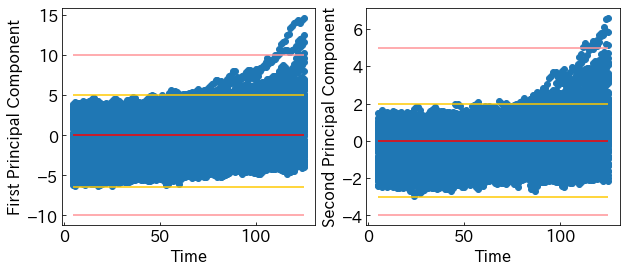

In [54]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].scatter("Time", "component1", data=pca2_df)

ax[0].hlines(5, xmin=5, xmax=125, color='#ffc900')
ax[0].hlines(-6.5, xmin=5, xmax=125, color='#ffc900')
ax[0].hlines(mean_c1, xmin=5, xmax=125, color='red')
ax[0].hlines(10, xmin=5, xmax=125, color='#ff9396')
ax[0].hlines(-10, xmin=5, xmax=125, color='#ff9396')

ax[0].set_xlabel("Time")
ax[0].set_ylabel("First Principal Component")

ax[1].scatter("Time", "component2", data=pca2_df)
ax[1].hlines(2, xmin=5, xmax=125, color='#ffc900')
ax[1].hlines(-3, xmin=5, xmax=125, color='#ffc900')
ax[1].hlines(mean_c2, xmin=5, xmax=125, color='red')
ax[1].hlines(5, xmin=5, xmax=125, color='#ff9396')
ax[1].hlines(-4, xmin=5, xmax=125, color='#ff9396')

ax[1].set_xlabel("Time")
ax[1].set_ylabel("Second Principal Component");

### アラム限界を設定

In [55]:
# AlarmRegionVertices
x_position_alarm_region = [-10, -10, 15, 15, -10]
y_position_alarm_region = [-4, 8, 8, -4, -4]

# AWarningRegionVertices
x_position_warning_region = [-7, -7, 10, 10, -7]
y_position_warning_region = [-4, 5, 5, -4, -4]

# NormalRegionVertices
x_position_normal_region = [-6.5, -6.5, 5, 5, -6.5]
y_position_normal_region = [-3, 2, 2, -3, -3]

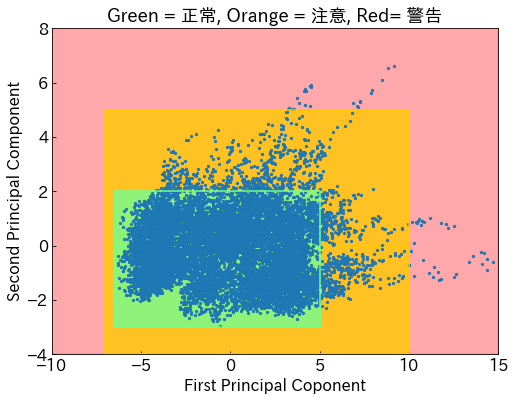

In [56]:
plt.figure(figsize=(8,6))

plt.plot(x_position_alarm_region, y_position_alarm_region, '#ff9396')
plt.fill_between(x_position_alarm_region, y1=y_position_alarm_region,y2=8, color='#ff9396', alpha=0.8)

plt.plot(x_position_warning_region, y_position_warning_region, '#ffc900')
plt.fill_between(x_position_warning_region, y1=y_position_warning_region, color='#ffc900', alpha=0.8)

plt.plot(x_position_normal_region, y_position_normal_region, '#71ff8d')
plt.fill_between(x_position_normal_region, y1=y_position_normal_region, color='#71ff8d', alpha=0.8)

plt.scatter("component1", "component2", data=pca2_df, s=5)

plt.xlabel("First Principal Coponent")
plt.ylabel("Second Principal Component")
plt.xlim([-10,15])
plt.ylim([-4,8])
plt.title("Green = 正常, Orange = 注意, Red= 警告");

In [57]:
capture_rate = 100 - len(pca2_df.query("component1 > 5 | component1 < -6.5 | component2 > 2 | component2 < -3")) / len(pca2_df) * 100
print(f"Percent of points captured by 'normal' conditions: {capture_rate:.1f}%")

Percent of points captured by 'normal' conditions: 90.0%


In [58]:
capture_rate = 100 - len(pca2_df.query("component1 > 10 | component1 < -7 | component2 >5 | component2 < -4")) / len(pca2_df) * 100
print(f"Percent of points captured by 'normal' + 'warn' conditions: {capture_rate:.1f}%")

Percent of points captured by 'normal' + 'warn' conditions: 99.5%


## 次元削減のデータを保存

In [59]:
save_data_dir = Path("../data/preprocessed_data/")

In [60]:
pca2_df.to_pickle(save_data_dir / "pca_2dim.pickle")